In [1]:
import os
import imageio
import pickle
import pandas as pd
import numpy as np
import PyNAFF as pnf
import scipy.io as sio 
import matplotlib.cm as cm
from math import log10, floor
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit

In [2]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5

## Function declarations

In [3]:
def make_directory(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Successfully created the directory %s " % path)  

In [4]:
########################################################################
# Read PTC Twiss and return dictionary of columns/values
########################################################################
def Read_PTC_Twiss_Return_Dict(filename, verbose=True):
    # Dictionary for output
    d = dict()
    d['HEADER_FILENAME'] = [filename]
    keywords = ''
    
    # First we open and count header lines
    fin0=open(filename,'r').readlines()
    headerlines = 0
    for l in fin0:
        # Store each header line
        headerlines = headerlines + 1
        # Stop if we find the line starting '* NAME'
        if '* NAME' in l:
            keywords = l
            break
        # Store the headers as d['HEADER_<name>'] = <value>
        else:
            #try:
            #    d[str('HEADER_'+l.split()[1])]=[float(l.split()[-1])]     
            #except ValueError:
            #    d[str('HEADER_'+l.split()[1])]=[str(l.split()[-1])]   
            if '"' in l:
                d[str('HEADER_'+l.split()[1])]=[str(l.split('"')[1])]
            else:
                d[str('HEADER_'+l.split()[1])]=[float(l.split()[-1])]                 
    headerlines = headerlines + 1    
    
    if verbose: print '\nRead_PTC_Twiss_Return_Dict found Keywords: \n',keywords
    
    # Make a list of column keywords to return (as an aid to iterating)
    dict_keys = []
    for key in keywords.split():
        dict_keys.append(key)
    dict_keys.remove('*')
    
    if verbose: print '\nRead_PTC_Twiss_Return_Dict Dict Keys: \n',dict_keys
    
    # Initialise empty dictionary entries for column keywords 
    for key in dict_keys:
        d[key]=[]
        
    if verbose: 
        print '\nRead_PTC_Twiss_Return_Dict header only dictionary \n'
        for i in d:
            print i, d[i]
    
    # Strip header
    fin1=open(filename,'r').readlines()[headerlines:]   
    
    # Populate the dictionary line by line
    for l in fin1:
        i = -1        
        for value in l.split():
            i = i+1
            if 'NAME' in dict_keys[i]:
                d[dict_keys[i]].append(str(value))
            else:
                d[dict_keys[i]].append(float(value))    
                
    # Return list of column keywords 'dict_keys', and dictionary 'd'
    return dict_keys, d

In [5]:
def return_initial_Parameter(d, parameter, sig_limit=3):
    return d[parameter][0] 

def print_Twiss_Dict_Parameter(d, parameter, sig_limit=3):
    print parameter, ' = ', round_sig(d[parameter][0],sig_limit) 

def print_Twiss_Dict_Tunes(d, sig_limit=3):
    print '(Qx, Qy) = (', round_sig(d['HEADER_Q1'][0],sig_limit) , ',' , round_sig(d['HEADER_Q2'][0],sig_limit) , ')'

def Extract_initial_values(master_dict, name, wp_dict, vals=['BETX', 'DISP1']):
    # Note name format is 'V_24'
    master_dict[name] = dict()
    for value in vals:
        master_dict[name][value] = wp_dict[value][0]    

In [6]:
def harmonic_fn(x, a, b, c, d):
    return a + b*np.cos(c + 2*np.pi*d*x)

In [7]:
def quadratic(x, a, m, c):
    return a*x**2 + x*m + c

In [8]:
def cubic(x, a, m, c, b):
    return a*x**2 + x*m + c + b*x**3

In [9]:
def Md_fit(x, a, b, c, d):
        return a + b*np.cos(c*x+d)

In [10]:
def Md_ramp_fit(x, a, b, c, d):
    return a + b*(x-1)*np.cos(c*(x-1)+d)

In [11]:
def round_sig(x, sig=4):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [12]:
def add_input_file(dd, filename, label, verbose=True):
	f = filename
	p = dict()
	sio.loadmat(f, mdict=p)
	dd[label] = p
	if verbose: print '\tAdded output data from ', filename, '\t dictionary key: ', label
	return dd

In [13]:
def is_non_zero_file(fpath, verbose=True):  
	if verbose: print '\t\tis_non_zero_file:: Checking file ', fpath
	if verbose: print '\t\tis_non_zero_file:: File exists = ', os.path.isfile(fpath)
	if verbose: print '\t\tis_non_zero_file:: Size > 3 bytes = ', os.path.getsize(fpath)
	return os.path.isfile(fpath) and os.path.getsize(fpath) > 3

In [14]:
def make_dispersion_vector_dict(d, bunch_output_dir, verbose=True):
    maxi = 30
    turns = range(0,maxi)   
    
    for t in turns:
        if t <= 9: inputs = str(bunch_output_dir +'/bunch_output/mainbunch_00000' + str(int(t)) + '.mat')
        else:      inputs = str(bunch_output_dir +'/bunch_output/mainbunch_0000' + str(int(t)) + '.mat' )
        
        if verbose: print '\nInput file location: ', inputs
            
        if is_non_zero_file(inputs, verbose):            
            d = add_input_file(d, inputs, (t+1), verbose=verbose)
        else:
            print 'make_dispersion_vector_dict:: input file does not exist'
            exit(0)
            
    d = add_input_file(d, str(bunch_output_dir +'/bunch_output/mainbunch_-000001.mat'), 0, verbose=verbose)
    return d    

In [15]:
def LorentzBeta(gamma):
    return np.sqrt( 1. - (1./gamma**2) )

In [16]:
PTC_gamma = 2.49038064
beta = LorentzBeta(PTC_gamma)
E = 2336654575.29 * 1E-9 
beta

0.9158392756488949

## Load dispersion vector data

In [17]:
H_No_Mismatch_Dict = dict()

d0_H_07 = dict()
d0_H_07 = make_dispersion_vector_dict(d0_H_07, '0_H_07', verbose=False)
H_No_Mismatch_Dict['0_H_07'] = d0_H_07

d0_H_08 = dict()
d0_H_08 = make_dispersion_vector_dict(d0_H_08, '0_H_08', verbose=False)
H_No_Mismatch_Dict['0_H_08'] = d0_H_08

d0_H_09 = dict()
d0_H_09 = make_dispersion_vector_dict(d0_H_09, '0_H_09', verbose=False)
H_No_Mismatch_Dict['0_H_09'] = d0_H_09

d0_H_10 = dict()
d0_H_10 = make_dispersion_vector_dict(d0_H_10, '0_H_10', verbose=False)
H_No_Mismatch_Dict['0_H_10'] = d0_H_10

d0_H_11 = dict()
d0_H_11 = make_dispersion_vector_dict(d0_H_11, '0_H_11', verbose=False)
H_No_Mismatch_Dict['0_H_11'] = d0_H_11

d0_H_12 = dict()
d0_H_12 = make_dispersion_vector_dict(d0_H_12, '0_H_12', verbose=False)
H_No_Mismatch_Dict['0_H_12'] = d0_H_12

d0_H_13 = dict()
d0_H_13 = make_dispersion_vector_dict(d0_H_13, '0_H_13', verbose=False)
H_No_Mismatch_Dict['0_H_13'] = d0_H_13

d0_H_14 = dict()
d0_H_14 = make_dispersion_vector_dict(d0_H_14, '0_H_14', verbose=False)
H_No_Mismatch_Dict['0_H_14'] = d0_H_14

d0_H_15 = dict()
d0_H_15 = make_dispersion_vector_dict(d0_H_15, '0_H_15', verbose=False)
H_No_Mismatch_Dict['0_H_15'] = d0_H_15

d0_H_16 = dict()
d0_H_16 = make_dispersion_vector_dict(d0_H_16, '0_H_16', verbose=False)
H_No_Mismatch_Dict['0_H_16'] = d0_H_16

d0_H_17 = dict()
d0_H_17 = make_dispersion_vector_dict(d0_H_17, '0_H_17', verbose=False)
H_No_Mismatch_Dict['0_H_17'] = d0_H_17

d0_H_18 = dict()
d0_H_18 = make_dispersion_vector_dict(d0_H_18, '0_H_18', verbose=False)
H_No_Mismatch_Dict['0_H_18'] = d0_H_18

d0_H_19 = dict()
d0_H_19 = make_dispersion_vector_dict(d0_H_19, '0_H_19', verbose=False)
H_No_Mismatch_Dict['0_H_19'] = d0_H_19

d0_H_20 = dict()
d0_H_20 = make_dispersion_vector_dict(d0_H_20, '0_H_20', verbose=False)
H_No_Mismatch_Dict['0_H_20'] = d0_H_20

d0_H_21 = dict()
d0_H_21 = make_dispersion_vector_dict(d0_H_21, '0_H_21', verbose=False)
H_No_Mismatch_Dict['0_H_21'] = d0_H_21

H_No_Mismatch = [d0_H_07, d0_H_08, d0_H_09, d0_H_10, d0_H_11, d0_H_12, d0_H_13, d0_H_14, d0_H_15, d0_H_16, d0_H_17, d0_H_18, d0_H_19, d0_H_20, d0_H_21]

In [18]:
H_Mismatch_Dict = dict()

d1_H_07 = dict()
d1_H_07 = make_dispersion_vector_dict(d1_H_07, '1_H_07', verbose=False)
H_Mismatch_Dict['1_H_07'] = d1_H_07

d1_H_08 = dict()
d1_H_08 = make_dispersion_vector_dict(d1_H_08, '1_H_08', verbose=False)
H_Mismatch_Dict['1_H_08'] = d1_H_08

d1_H_09 = dict()
d1_H_09 = make_dispersion_vector_dict(d1_H_09, '1_H_09', verbose=False)
H_Mismatch_Dict['1_H_09'] = d1_H_09

d1_H_10 = dict()
d1_H_10 = make_dispersion_vector_dict(d1_H_10, '1_H_10', verbose=False)
H_Mismatch_Dict['1_H_10'] = d1_H_10

d1_H_11 = dict()
d1_H_11 = make_dispersion_vector_dict(d1_H_11, '1_H_11', verbose=False)
H_Mismatch_Dict['1_H_11'] = d1_H_11

d1_H_12 = dict()
d1_H_12 = make_dispersion_vector_dict(d1_H_12, '1_H_12', verbose=False)
H_Mismatch_Dict['1_H_12'] = d1_H_12

d1_H_13 = dict()
d1_H_13 = make_dispersion_vector_dict(d1_H_13, '1_H_13', verbose=False)
H_Mismatch_Dict['1_H_13'] = d1_H_13

d1_H_14 = dict()
d1_H_14 = make_dispersion_vector_dict(d1_H_14, '1_H_14', verbose=False)
H_Mismatch_Dict['1_H_14'] = d1_H_14

d1_H_15 = dict()
d1_H_15 = make_dispersion_vector_dict(d1_H_15, '1_H_15', verbose=False)
H_Mismatch_Dict['1_H_15'] = d1_H_15

d1_H_16 = dict()
d1_H_16 = make_dispersion_vector_dict(d1_H_16, '1_H_16', verbose=False)
H_Mismatch_Dict['1_H_16'] = d1_H_16

d1_H_17 = dict()
d1_H_17 = make_dispersion_vector_dict(d1_H_17, '1_H_17', verbose=False)
H_Mismatch_Dict['1_H_17'] = d1_H_17

d1_H_18 = dict()
d1_H_18 = make_dispersion_vector_dict(d1_H_18, '1_H_18', verbose=False)
H_Mismatch_Dict['1_H_18'] = d1_H_18

d1_H_19 = dict()
d1_H_19 = make_dispersion_vector_dict(d1_H_19, '1_H_19', verbose=False)
H_Mismatch_Dict['1_H_19'] = d1_H_19

d1_H_20 = dict()
d1_H_20 = make_dispersion_vector_dict(d1_H_20, '1_H_20', verbose=False)
H_Mismatch_Dict['1_H_20'] = d1_H_20

d1_H_21 = dict()
d1_H_21 = make_dispersion_vector_dict(d1_H_21, '1_H_21', verbose=False)
H_Mismatch_Dict['1_H_21'] = d1_H_21

H_Mismatch = [d1_H_07, d1_H_08, d1_H_09, d1_H_10, d1_H_11, d1_H_12, d1_H_13, d1_H_14, d1_H_15, d1_H_16, d1_H_17, d1_H_18, d1_H_19, d1_H_20, d1_H_21]

In [19]:
V_No_Mismatch_Dict = dict()

d0_V_10 = dict()
d0_V_10 = make_dispersion_vector_dict(d0_V_10, '0_V_10', verbose=False)
V_No_Mismatch_Dict['0_V_10'] = d0_V_10

d0_V_11 = dict()
d0_V_11 = make_dispersion_vector_dict(d0_V_11, '0_V_11', verbose=False)
V_No_Mismatch_Dict['0_V_11'] = d0_V_11

d0_V_12 = dict()
d0_V_12 = make_dispersion_vector_dict(d0_V_12, '0_V_12', verbose=False)
V_No_Mismatch_Dict['0_V_12'] = d0_V_12

d0_V_13 = dict()
d0_V_13 = make_dispersion_vector_dict(d0_V_13, '0_V_13', verbose=False)
V_No_Mismatch_Dict['0_V_13'] = d0_V_13

d0_V_14 = dict()
d0_V_14 = make_dispersion_vector_dict(d0_V_14, '0_V_14', verbose=False)
V_No_Mismatch_Dict['0_V_14'] = d0_V_14

d0_V_15 = dict()
d0_V_15 = make_dispersion_vector_dict(d0_V_15, '0_V_15', verbose=False)
V_No_Mismatch_Dict['0_V_15'] = d0_V_15

d0_V_16 = dict()
d0_V_16 = make_dispersion_vector_dict(d0_V_16, '0_V_16', verbose=False)
V_No_Mismatch_Dict['0_V_16'] = d0_V_16

d0_V_17 = dict()
d0_V_17 = make_dispersion_vector_dict(d0_V_17, '0_V_17', verbose=False)
V_No_Mismatch_Dict['0_V_17'] = d0_V_17

d0_V_18 = dict()
d0_V_18 = make_dispersion_vector_dict(d0_V_18, '0_V_18', verbose=False)
V_No_Mismatch_Dict['0_V_18'] = d0_V_18

d0_V_19 = dict()
d0_V_19 = make_dispersion_vector_dict(d0_V_19, '0_V_19', verbose=False)
V_No_Mismatch_Dict['0_V_19'] = d0_V_19

d0_V_20 = dict()
d0_V_20 = make_dispersion_vector_dict(d0_V_20, '0_V_20', verbose=False)
V_No_Mismatch_Dict['0_V_20'] = d0_V_20

d0_V_21 = dict()
d0_V_21 = make_dispersion_vector_dict(d0_V_21, '0_V_21', verbose=False)
V_No_Mismatch_Dict['0_V_21'] = d0_V_21

d0_V_22 = dict()
d0_V_22 = make_dispersion_vector_dict(d0_V_22, '0_V_22', verbose=False)
V_No_Mismatch_Dict['0_V_22'] = d0_V_22

d0_V_23 = dict()
d0_V_23 = make_dispersion_vector_dict(d0_V_23, '0_V_23', verbose=False)
V_No_Mismatch_Dict['0_V_23'] = d0_V_23

d0_V_24 = dict()
d0_V_24 = make_dispersion_vector_dict(d0_V_24, '0_V_24', verbose=False)
V_No_Mismatch_Dict['0_V_24'] = d0_V_24

V_No_Mismatch = [d0_V_10, d0_V_11, d0_V_12, d0_V_13, d0_V_14, d0_V_15, d0_V_16, d0_V_17, d0_V_18, d0_V_19, d0_V_20, d0_V_21, d0_V_22, d0_V_23, d0_V_24 ]

In [20]:
V_Mismatch_Dict = dict()

d1_V_10 = dict()
d1_V_10 = make_dispersion_vector_dict(d1_V_10, '1_V_10', verbose=False)
V_Mismatch_Dict['1_V_10'] = d1_V_10

d1_V_11 = dict()
d1_V_11 = make_dispersion_vector_dict(d1_V_11, '1_V_11', verbose=False)
V_Mismatch_Dict['1_V_11'] = d1_V_11

d1_V_12 = dict()
d1_V_12 = make_dispersion_vector_dict(d1_V_12, '1_V_12', verbose=False)
V_Mismatch_Dict['1_V_12'] = d1_V_12

d1_V_13 = dict()
d1_V_13 = make_dispersion_vector_dict(d1_V_13, '1_V_13', verbose=False)
V_Mismatch_Dict['1_V_13'] = d1_V_13

d1_V_14 = dict()
d1_V_14 = make_dispersion_vector_dict(d1_V_14, '1_V_14', verbose=False)
V_Mismatch_Dict['1_V_14'] = d1_V_14

d1_V_15 = dict()
d1_V_15 = make_dispersion_vector_dict(d1_V_15, '1_V_15', verbose=False)
V_Mismatch_Dict['1_V_15'] = d1_V_15

d1_V_16 = dict()
d1_V_16 = make_dispersion_vector_dict(d1_V_16, '1_V_16', verbose=False)
V_Mismatch_Dict['1_V_16'] = d1_V_16

d1_V_17 = dict()
d1_V_17 = make_dispersion_vector_dict(d1_V_17, '1_V_17', verbose=False)
V_Mismatch_Dict['1_V_17'] = d1_V_17

d1_V_18 = dict()
d1_V_18 = make_dispersion_vector_dict(d1_V_18, '1_V_18', verbose=False)
V_Mismatch_Dict['1_V_18'] = d1_V_18

d1_V_19 = dict()
d1_V_19 = make_dispersion_vector_dict(d1_V_19, '1_V_19', verbose=False)
V_Mismatch_Dict['1_V_19'] = d1_V_19

d1_V_20 = dict()
d1_V_20 = make_dispersion_vector_dict(d1_V_20, '1_V_20', verbose=False)
V_Mismatch_Dict['1_V_20'] = d1_V_20

d1_V_21 = dict()
d1_V_21 = make_dispersion_vector_dict(d1_V_21, '1_V_21', verbose=False)
V_Mismatch_Dict['1_V_21'] = d1_V_21

d1_V_22 = dict()
d1_V_22 = make_dispersion_vector_dict(d1_V_22, '1_V_22', verbose=False)
V_Mismatch_Dict['1_V_22'] = d1_V_22

d1_V_23 = dict()
d1_V_23 = make_dispersion_vector_dict(d1_V_23, '1_V_23', verbose=False)
V_Mismatch_Dict['1_V_23'] = d1_V_23

d1_V_24 = dict()
d1_V_24 = make_dispersion_vector_dict(d1_V_24, '1_V_24', verbose=False)
V_Mismatch_Dict['1_V_24'] = d1_V_24

V_Mismatch = [d1_V_10, d1_V_11, d1_V_12, d1_V_13, d1_V_14, d1_V_15, d1_V_16, d1_V_17, d1_V_18, d1_V_19, d1_V_20, d1_V_21, d1_V_22, d1_V_23, d1_V_24 ]

## Load PTC Twiss

In [21]:
LEQ_H_07_keys, LEQ_H_07 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_07.tfs')
LEQ_H_08_keys, LEQ_H_08 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_08.tfs')
LEQ_H_09_keys, LEQ_H_09 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_09.tfs')
LEQ_H_10_keys, LEQ_H_10 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_10.tfs')
LEQ_H_11_keys, LEQ_H_11 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_11.tfs')
LEQ_H_12_keys, LEQ_H_12 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_12.tfs')
LEQ_H_13_keys, LEQ_H_13 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_13.tfs')
LEQ_H_14_keys, LEQ_H_14 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_14.tfs')
LEQ_H_15_keys, LEQ_H_15 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_15.tfs')
LEQ_H_16_keys, LEQ_H_16 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_16.tfs')
LEQ_H_17_keys, LEQ_H_17 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_17.tfs')
LEQ_H_18_keys, LEQ_H_18 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_18.tfs')
LEQ_H_19_keys, LEQ_H_19 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_19.tfs')
LEQ_H_20_keys, LEQ_H_20 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_20.tfs')
LEQ_H_21_keys, LEQ_H_21 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/H_21.tfs')
LEQ_H_List = [LEQ_H_07, LEQ_H_08, LEQ_H_09, LEQ_H_10, LEQ_H_11, LEQ_H_12, LEQ_H_13, LEQ_H_14, LEQ_H_15, LEQ_H_16, LEQ_H_17, LEQ_H_18, LEQ_H_19, LEQ_H_20, LEQ_H_21]


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1329643408]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [10.01946085]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [24.15254239]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02827408041]
HEADER_BETA_X_MAX [29.23376144]
HEADER_BETA_X_MIN [10.01946085]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT

HEADER_BETA32MAX [0.0]
HEADER_DISP2MAX [0.4485899168]
HEADER_XCORMS [0.0]
HEADER_DATE ['17/08/20']
HEADER_DISP2MIN [-0.4454285814]
HEADER_BCURRENT [0.0]
HEADER_Q1 [0.1395126241]
HEADER_Q2 [0.2401284492]
HEADER_BETA22MIN [11.43408499]
PX []
PY []
HEADER_PTCOMIN [0.0]
HEADER_GAMMA [2.49038064]
HEADER_DISP3MAX [0.0]
HEADER_QS [0.0]
S []
HEADER_BETA21MIN [0.0]
HEADER_BETA_Y_MAX [23.65778001]
HEADER_ENERGY [2.336654539]
HEADER_BETA31MIN [0.0]
HEADER_SEQUENCE ['PS']
HEADER_PXCORMS [0.0]
HEADER_BETA_Y_MIN [11.43408499]
HEADER_MASS [0.938272046]
HEADER_DISP1MIN [0.0]
HEADER_DISP1MAX [3.990237966]
HEADER_YCORMS [0.0]
HEADER_BETA23MIN [0.0]
HEADER_ORBIT_Y [0.0]
HEADER_ORBIT_X [0.0]
HEADER_EX [1.0]
HEADER_EY [1.0]
HEADER_ET [1.0]
BETY []
BETX []
HEADER_XCOMIN [0.0]
HEADER_YCOMIN [0.0]
ALFY []
ALFX []
HEADER_BETA23MAX [0.0]
MU1 []
NAME []
MU2 []
HEADER_TYPE ['TWISS']
HEADER_FILENAME ['../PTC_Twiss/H_14.tfs']
HEADER_YCOMAX [0.0]
HEADER_XCOMAX [0.0]
HEADER_TIME ['09.41.20']
HEADER_SIGT [0.0]
HEADER_

HEADER_ENERGY [2.336654539]
HEADER_BETA31MIN [0.0]
HEADER_SEQUENCE ['PS']
HEADER_PXCORMS [0.0]
HEADER_BETA_Y_MIN [11.51436908]
HEADER_MASS [0.938272046]
HEADER_DISP1MIN [0.0]
HEADER_DISP1MAX [3.526245385]
HEADER_YCORMS [0.0]
HEADER_BETA23MIN [0.0]
HEADER_ORBIT_Y [0.0]
HEADER_ORBIT_X [0.0]
HEADER_EX [1.0]
HEADER_EY [1.0]
HEADER_ET [1.0]
BETY []
BETX []
HEADER_XCOMIN [0.0]
HEADER_YCOMIN [0.0]
ALFY []
ALFX []
HEADER_BETA23MAX [0.0]
MU1 []
NAME []
MU2 []
HEADER_TYPE ['TWISS']
HEADER_FILENAME ['../PTC_Twiss/H_21.tfs']
HEADER_YCOMAX [0.0]
HEADER_XCOMAX [0.0]
HEADER_TIME ['09.41.16']
HEADER_SIGT [0.0]
HEADER_DISP3MIN [0.0]
HEADER_ORBIT_-CT [0.0]
HEADER_DQ2 [-7.793328622]
HEADER_DQ1 [-5.764661948]
HEADER_PYCOMIN [0.0]
HEADER_SIGE [0.0]
HEADER_NPART [0.0]
HEADER_LENGTH [628.3185]
HEADER_NAME ['PTC_TWISS']
HEADER_PYCOMAX [0.0]
DISP1 []
DISP3 []
DISP2 []
DISP4 []
HEADER_ORIGIN ['MAD-X 5.02.00 Linux 64']
Y []
HEADER_PXCOMAX [0.0]
HEADER_CHARGE [1.0]
HEADER_DISP4MAX [0.0]
HEADER_DISP4MIN [0.0]


In [22]:
for d in LEQ_H_List:
    print_Twiss_Dict_Tunes(d,2)

(Qx, Qy) = ( 0.07 , 0.24 )
(Qx, Qy) = ( 0.08 , 0.24 )
(Qx, Qy) = ( 0.09 , 0.24 )
(Qx, Qy) = ( 0.1 , 0.24 )
(Qx, Qy) = ( 0.11 , 0.24 )
(Qx, Qy) = ( 0.12 , 0.24 )
(Qx, Qy) = ( 0.13 , 0.24 )
(Qx, Qy) = ( 0.14 , 0.24 )
(Qx, Qy) = ( 0.15 , 0.24 )
(Qx, Qy) = ( 0.16 , 0.24 )
(Qx, Qy) = ( 0.17 , 0.24 )
(Qx, Qy) = ( 0.18 , 0.24 )
(Qx, Qy) = ( 0.19 , 0.24 )
(Qx, Qy) = ( 0.2 , 0.24 )
(Qx, Qy) = ( 0.21 , 0.24 )


In [23]:
LEQ_V_10_keys, LEQ_V_10 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_10.tfs')
LEQ_V_11_keys, LEQ_V_11 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_11.tfs')
LEQ_V_12_keys, LEQ_V_12 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_12.tfs')
LEQ_V_13_keys, LEQ_V_13 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_13.tfs')
LEQ_V_14_keys, LEQ_V_14 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_14.tfs')
LEQ_V_15_keys, LEQ_V_15 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_15.tfs')
LEQ_V_16_keys, LEQ_V_16 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_16.tfs')
LEQ_V_17_keys, LEQ_V_17 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_17.tfs')
LEQ_V_18_keys, LEQ_V_18 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_18.tfs')
LEQ_V_19_keys, LEQ_V_19 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_19.tfs')
LEQ_V_20_keys, LEQ_V_20 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_20.tfs')
LEQ_V_21_keys, LEQ_V_21 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_21.tfs')
LEQ_V_22_keys, LEQ_V_22 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_22.tfs')
LEQ_V_23_keys, LEQ_V_23 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_23.tfs')
LEQ_V_24_keys, LEQ_V_24 = Read_PTC_Twiss_Return_Dict('../PTC_Twiss/V_24.tfs')
LEQ_V_List = [LEQ_V_10, LEQ_V_11, LEQ_V_12, LEQ_V_13, LEQ_V_14, LEQ_V_15, LEQ_V_16, LEQ_V_17, LEQ_V_18, LEQ_V_19, LEQ_V_20, LEQ_V_21, LEQ_V_22, LEQ_V_23, LEQ_V_24]


Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header only dictionary 

HEADER_ETA_C [-0.1342599162]
HEADER_TCOMIN [0.0]
HEADER_BETA11MIN [11.04248161]
HEADER_DELTAP [0.0]
HEADER_BETA33MIN [0.0]
HEADER_TCOMAX [0.0]
HEADER_PC [2.14]
HEADER_BETA22MAX [28.94231883]
HEADER_BETA12MIN [0.0]
HEADER_ALPHA_C [0.02697850494]
HEADER_BETA_X_MAX [24.54387774]
HEADER_BETA_X_MIN [11.04248161]
HEADER_ALPHA_C_P2 [-1000000.0]
HEADER_ALPHA_C_P3 [-1000000.0]
HEADER_BETA13MIN [0.0]
HEADER_TITLE ['Flat file generation for PT

HEADER_XCOMAX [0.0]
HEADER_TIME ['09.41.16']
HEADER_SIGT [0.0]
HEADER_DISP3MIN [0.0]
HEADER_ORBIT_-CT [0.0]
HEADER_DQ2 [-7.7868172]
HEADER_DQ1 [-5.716540539]
HEADER_PYCOMIN [0.0]
HEADER_SIGE [0.0]
HEADER_NPART [0.0]
HEADER_LENGTH [628.3185]
HEADER_NAME ['PTC_TWISS']
HEADER_PYCOMAX [0.0]
DISP1 []
DISP3 []
DISP2 []
DISP4 []
HEADER_ORIGIN ['MAD-X 5.02.00 Linux 64']
Y []
HEADER_PXCOMAX [0.0]
HEADER_CHARGE [1.0]
HEADER_DISP4MAX [0.0]
HEADER_DISP4MIN [0.0]

Read_PTC_Twiss_Return_Dict found Keywords: 
* NAME                                S               BETX               BETY               ALFX               ALFY              DISP1              DISP2              DISP3              DISP4                MU1                MU2                  X                 PX                  Y                 PY 


Read_PTC_Twiss_Return_Dict Dict Keys: 
['NAME', 'S', 'BETX', 'BETY', 'ALFX', 'ALFY', 'DISP1', 'DISP2', 'DISP3', 'DISP4', 'MU1', 'MU2', 'X', 'PX', 'Y', 'PY']

Read_PTC_Twiss_Return_Dict header

HEADER_BETA11MAX [23.73464642]
HEADER_ALPHA_C_P [-0.5915379432]
HEADER_PXCOMIN [0.0]
HEADER_PYCORMS [0.0]
X []
HEADER_PARTICLE ['PROTON']
HEADER_KBUNCH [1.0]
HEADER_PTCORMS [0.0]
HEADER_GAMMA_TR [6.08483761]
HEADER_ORBIT_PT [0.0]
HEADER_BETA33MAX [0.0]
HEADER_BETA12MAX [0.0]
HEADER_ORBIT_PX [0.0]
HEADER_ORBIT_PY [0.0]
HEADER_PTCOMAX [0.0]
HEADER_BETA32MIN [0.0]
HEADER_BETA31MAX [0.0]
HEADER_TCORMS [0.0]
HEADER_BETA32MAX [0.0]
HEADER_DISP2MAX [0.3928257921]
HEADER_XCORMS [0.0]
HEADER_DATE ['17/08/20']
HEADER_DISP2MIN [-0.3978492813]
HEADER_BCURRENT [0.0]
HEADER_Q1 [0.2095137562]
HEADER_Q2 [0.20012511]
HEADER_BETA22MIN [11.36932189]
PX []
PY []
HEADER_PTCOMIN [0.0]
HEADER_GAMMA [2.49038064]
HEADER_DISP3MAX [0.0]
HEADER_QS [0.0]
S []
HEADER_BETA21MIN [0.0]
HEADER_BETA_Y_MAX [24.25346862]
HEADER_ENERGY [2.336654539]
HEADER_BETA31MIN [0.0]
HEADER_SEQUENCE ['PS']
HEADER_PXCORMS [0.0]
HEADER_BETA_Y_MIN [11.36932189]
HEADER_MASS [0.938272046]
HEADER_DISP1MIN [0.0]
HEADER_DISP1MAX [3.569280222]

In [24]:
for d in LEQ_V_List:
    print_Twiss_Dict_Tunes(d)

(Qx, Qy) = ( 0.21 , 0.1 )
(Qx, Qy) = ( 0.21 , 0.11 )
(Qx, Qy) = ( 0.21 , 0.12 )
(Qx, Qy) = ( 0.21 , 0.13 )
(Qx, Qy) = ( 0.21 , 0.14 )
(Qx, Qy) = ( 0.21 , 0.15 )
(Qx, Qy) = ( 0.21 , 0.16 )
(Qx, Qy) = ( 0.21 , 0.17 )
(Qx, Qy) = ( 0.21 , 0.18 )
(Qx, Qy) = ( 0.21 , 0.19 )
(Qx, Qy) = ( 0.21 , 0.2 )
(Qx, Qy) = ( 0.21 , 0.21 )
(Qx, Qy) = ( 0.21 , 0.22 )
(Qx, Qy) = ( 0.21 , 0.23 )
(Qx, Qy) = ( 0.21 , 0.24 )


# Create dictionary of initial BETX, DX for all tunes - needed for normalisation

In [25]:
LEQ_V_14['BETX'][0]

12.36665664

In [26]:
twiss_dict = dict()     

Extract_initial_values(twiss_dict, 'V_10', LEQ_V_10)
Extract_initial_values(twiss_dict, 'V_11', LEQ_V_11)
Extract_initial_values(twiss_dict, 'V_12', LEQ_V_12)
Extract_initial_values(twiss_dict, 'V_13', LEQ_V_13)
Extract_initial_values(twiss_dict, 'V_14', LEQ_V_14)
Extract_initial_values(twiss_dict, 'V_15', LEQ_V_15)
Extract_initial_values(twiss_dict, 'V_16', LEQ_V_16)
Extract_initial_values(twiss_dict, 'V_17', LEQ_V_17)
Extract_initial_values(twiss_dict, 'V_18', LEQ_V_18)
Extract_initial_values(twiss_dict, 'V_19', LEQ_V_19)
Extract_initial_values(twiss_dict, 'V_20', LEQ_V_20)
Extract_initial_values(twiss_dict, 'V_21', LEQ_V_21)
Extract_initial_values(twiss_dict, 'V_22', LEQ_V_22)
Extract_initial_values(twiss_dict, 'V_23', LEQ_V_23)
Extract_initial_values(twiss_dict, 'V_24', LEQ_V_24)

Extract_initial_values(twiss_dict, 'H_07', LEQ_H_07)
Extract_initial_values(twiss_dict, 'H_08', LEQ_H_08)
Extract_initial_values(twiss_dict, 'H_09', LEQ_H_09)
Extract_initial_values(twiss_dict, 'H_10', LEQ_H_10)
Extract_initial_values(twiss_dict, 'H_11', LEQ_H_11)
Extract_initial_values(twiss_dict, 'H_12', LEQ_H_12)
Extract_initial_values(twiss_dict, 'H_13', LEQ_H_13)
Extract_initial_values(twiss_dict, 'H_14', LEQ_H_14)
Extract_initial_values(twiss_dict, 'H_15', LEQ_H_15)
Extract_initial_values(twiss_dict, 'H_16', LEQ_H_16)
Extract_initial_values(twiss_dict, 'H_17', LEQ_H_17)
Extract_initial_values(twiss_dict, 'H_18', LEQ_H_18)
Extract_initial_values(twiss_dict, 'H_19', LEQ_H_19)
Extract_initial_values(twiss_dict, 'H_20', LEQ_H_20)
Extract_initial_values(twiss_dict, 'H_21', LEQ_H_21)



In [27]:
twiss_dict

{'H_07': {'BETX': 19.84948902, 'DISP1': 3.93488301},
 'H_08': {'BETX': 20.33893362, 'DISP1': 3.866761257},
 'H_09': {'BETX': 20.72166098, 'DISP1': 3.806972182},
 'H_10': {'BETX': 21.02688357, 'DISP1': 3.754316764},
 'H_11': {'BETX': 21.27416871, 'DISP1': 3.707614758},
 'H_12': {'BETX': 21.47709206, 'DISP1': 3.665848354},
 'H_13': {'BETX': 21.6453541, 'DISP1': 3.628177997},
 'H_14': {'BETX': 21.78606198, 'DISP1': 3.593921639},
 'H_15': {'BETX': 21.90453569, 'DISP1': 3.562526931},
 'H_16': {'BETX': 22.00483203, 'DISP1': 3.533545503},
 'H_17': {'BETX': 22.09009496, 'DISP1': 3.506611576},
 'H_18': {'BETX': 22.16279577, 'DISP1': 3.481424908},
 'H_19': {'BETX': 22.22490142, 'DISP1': 3.457737414},
 'H_20': {'BETX': 22.27799481, 'DISP1': 3.435342736},
 'H_21': {'BETX': 22.32336233, 'DISP1': 3.414068095},
 'V_10': {'BETX': 12.31655507, 'DISP1': 2.641941387},
 'V_11': {'BETX': 12.32914236, 'DISP1': 2.637001304},
 'V_12': {'BETX': 12.34169412, 'DISP1': 2.632067558},
 'V_13': {'BETX': 12.35420107,

# Attempt plotting

In [28]:
test_save_folder = 'Test_Plots'
make_directory(test_save_folder)

Creation of the directory Test_Plots failed


In [29]:
### Access the x data for turn n like:
n = 0
d1_H_07[n]['particles']['x'][0][0][0]

array([-5.16306721e-04,  9.80982771e-03, -1.03261344e-02,  3.29348668e-13,
        1.03261344e-02, -9.80982771e-03,  5.16306722e-04, -9.29352099e-03,
        1.03261344e-03, -8.77721427e-03,  1.54892017e-03, -8.26090755e-03,
        2.06522689e-03, -7.74460083e-03,  2.58153361e-03, -7.22829411e-03,
        3.09784033e-03, -6.71198738e-03,  3.61414705e-03, -6.19568066e-03,
        4.13045377e-03, -5.67937394e-03,  4.64676050e-03, -5.16306722e-03,
        5.16306722e-03, -4.64676050e-03,  5.67937394e-03, -4.13045377e-03,
        6.19568066e-03, -3.61414705e-03,  6.71198738e-03, -3.09784033e-03,
        7.22829411e-03, -2.58153361e-03,  7.74460083e-03, -2.06522689e-03,
        8.26090755e-03, -1.54892017e-03,  8.77721427e-03, -1.03261344e-03,
        9.29352099e-03])

In [30]:
### Access the x data for turn n like:
n = 0
d1_H_21[n]['particles']['x'][0][0][0]

array([-4.78040388e-04,  9.08276735e-03, -9.56080773e-03, -8.59742967e-13,
        9.56080773e-03, -9.08276735e-03,  4.78040386e-04, -8.60472696e-03,
        9.56080773e-04, -8.12668657e-03,  1.43412116e-03, -7.64864619e-03,
        1.91216155e-03, -7.17060580e-03,  2.39020193e-03, -6.69256541e-03,
        2.86824232e-03, -6.21452503e-03,  3.34628271e-03, -5.73648464e-03,
        3.82432309e-03, -5.25844425e-03,  4.30236348e-03, -4.78040387e-03,
        4.78040387e-03, -4.30236348e-03,  5.25844425e-03, -3.82432309e-03,
        5.73648464e-03, -3.34628271e-03,  6.21452503e-03, -2.86824232e-03,
        6.69256541e-03, -2.39020193e-03,  7.17060580e-03, -1.91216155e-03,
        7.64864619e-03, -1.43412116e-03,  8.12668657e-03, -9.56080774e-04,
        8.60472696e-03])

/usr/lib64/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


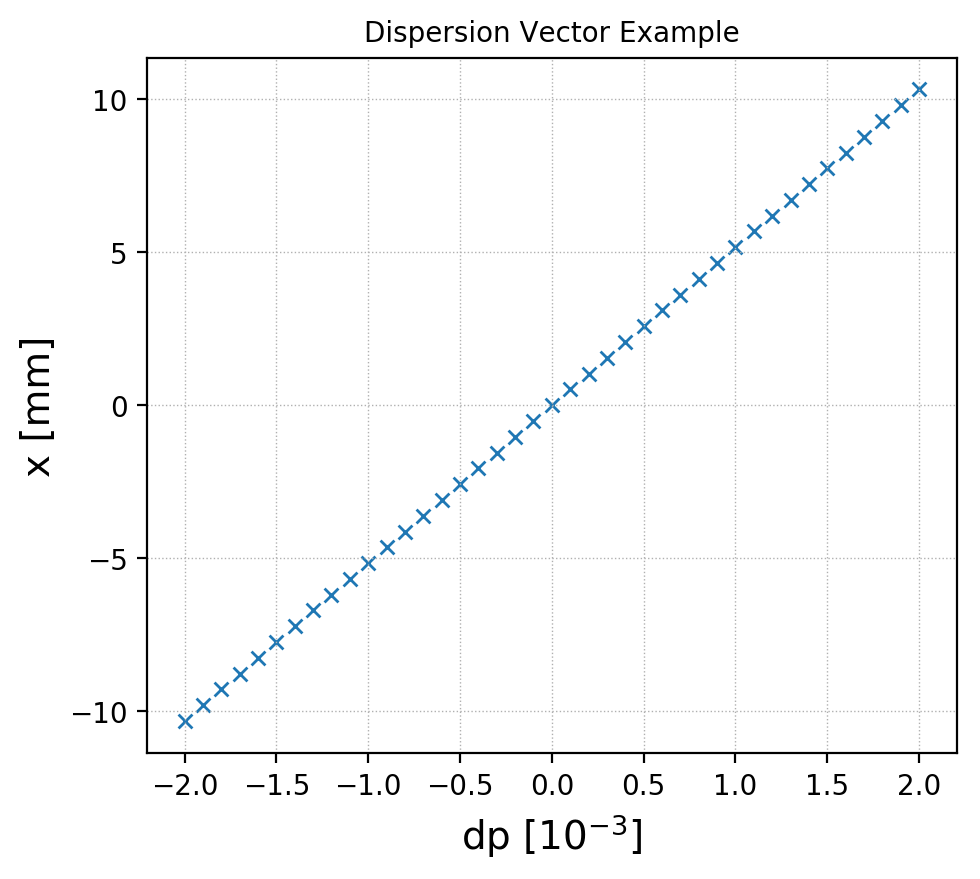

In [31]:
### Our dispersion vector can be plotted like:
n = 0;
fig1, ax1 = plt.subplots(1, tight_layout=True);

parameter1 = 'dE';
parameter2 = 'x';
multi1 = 1E3;
multi2 = 1E3;

ax1.set_title('Dispersion Vector Example');
ax1.set_xlabel(r'dp [$10^{-3}$]');
ax1.set_ylabel('x [mm]');
ax1.grid(which='both',linewidth=0.5, ls=':');
#ax1.set_ylim(-15, 15);

x = np.array(multi1 * d1_H_07[n]['particles'][parameter1][0][0][0]/E/beta**2) #Conversion from dE to dpp
y = np.array(multi2 * d1_H_07[n]['particles'][parameter2][0][0][0])

ax1.scatter(x, y, marker='x');

savename = test_save_folder +'/Dispersion_Vector_Example.png'
plt.savefig(savename);

/usr/lib64/python2.7/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Fitted linear dispersion =  5.163  m


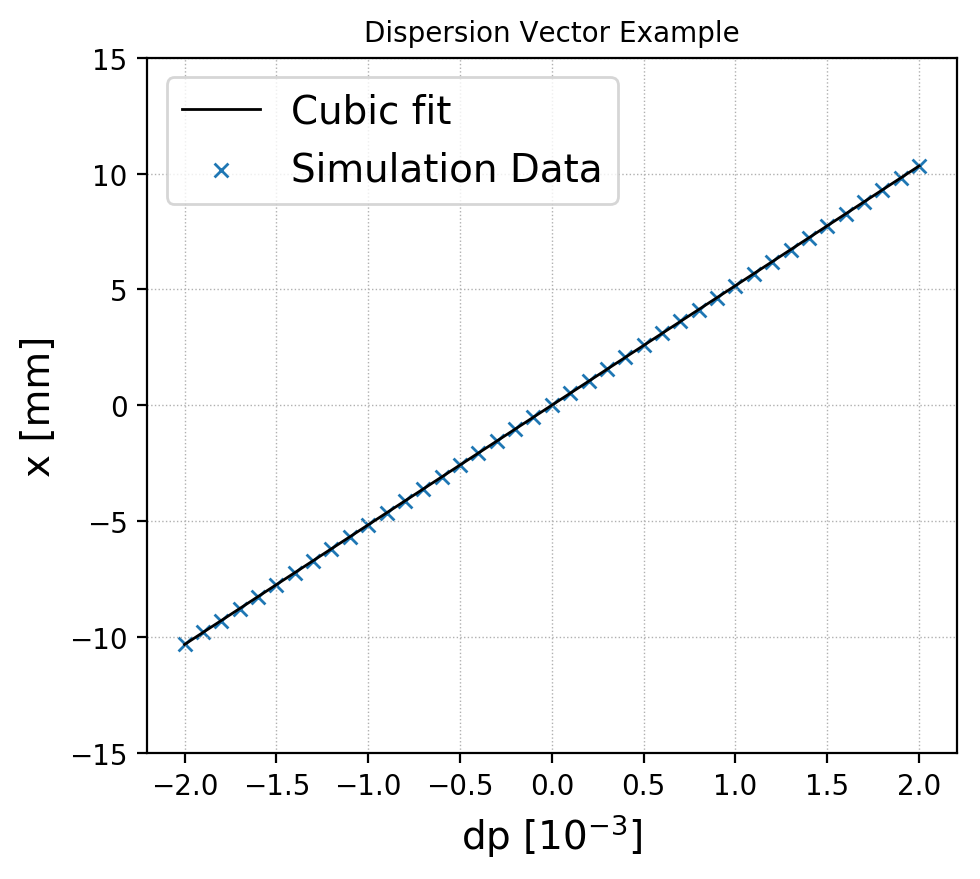

In [32]:
### Add fitting of the vector to find the linear dispersion:
n = 0;
fig1, ax1 = plt.subplots(1, tight_layout=True);

d = d1_H_07

D_test = []  
D2_test = [] 
D3_test = [] 
Intercept_test = []   

parameter1 = 'dE';
parameter2 = 'x';
multi1 = 1E3;
multi2 = 1E3;

ax1.set_title('Dispersion Vector Example');
ax1.set_xlabel(r'dp [$10^{-3}$]');
ax1.set_ylabel('x [mm]');
ax1.grid(which='both',linewidth=0.5, ls=':');
ax1.set_ylim(-15, 15);


x = np.array(multi1 * d[n]['particles'][parameter1][0][0][0]/E/beta**2) #Conversion from dE to dpp
y = np.array(multi2 * d[n]['particles'][parameter2][0][0][0])
ax1.scatter(x, y, marker='x', label='Simulation Data');

min_dp = np.min(x)
max_dp = np.max(x)
DELTAP_range = np.arange(min_dp, max_dp, 1E-3);

popt_test, pcov_test = curve_fit(cubic, x, y);
                                 
D_test.append(popt_test[1]);
D2_test.append(popt_test[0]);
D3_test.append(popt_test[3]);
Intercept_test.append(popt_test[2]);
ax1.plot(DELTAP_range, cubic(DELTAP_range,popt_test[0],popt_test[1],popt_test[2],popt_test[3]),'-k', label='Cubic fit');

ax1.legend();

savename = test_save_folder +'/Fitted_Dispersion_Vector_Example.png'
plt.savefig(savename);

print 'Fitted linear dispersion = ',round_sig(D_test[0]), ' m'


### Create a master dictionary to hold:
- All fitted dispersionn values D_1, D_2, D_3, and intercept D_i
- For all turns
- For all simulated cases in format 0_H_07

d[case][D_1] = [list of linear dispersion for all turns]
d[case][BETX] = initial horizontal beta function

In [33]:
master_dict = dict()

In [34]:
dispersion_vector_save_folder = 'Dispersion_Vectors'
make_directory(dispersion_vector_save_folder)

Creation of the directory Dispersion_Vectors failed


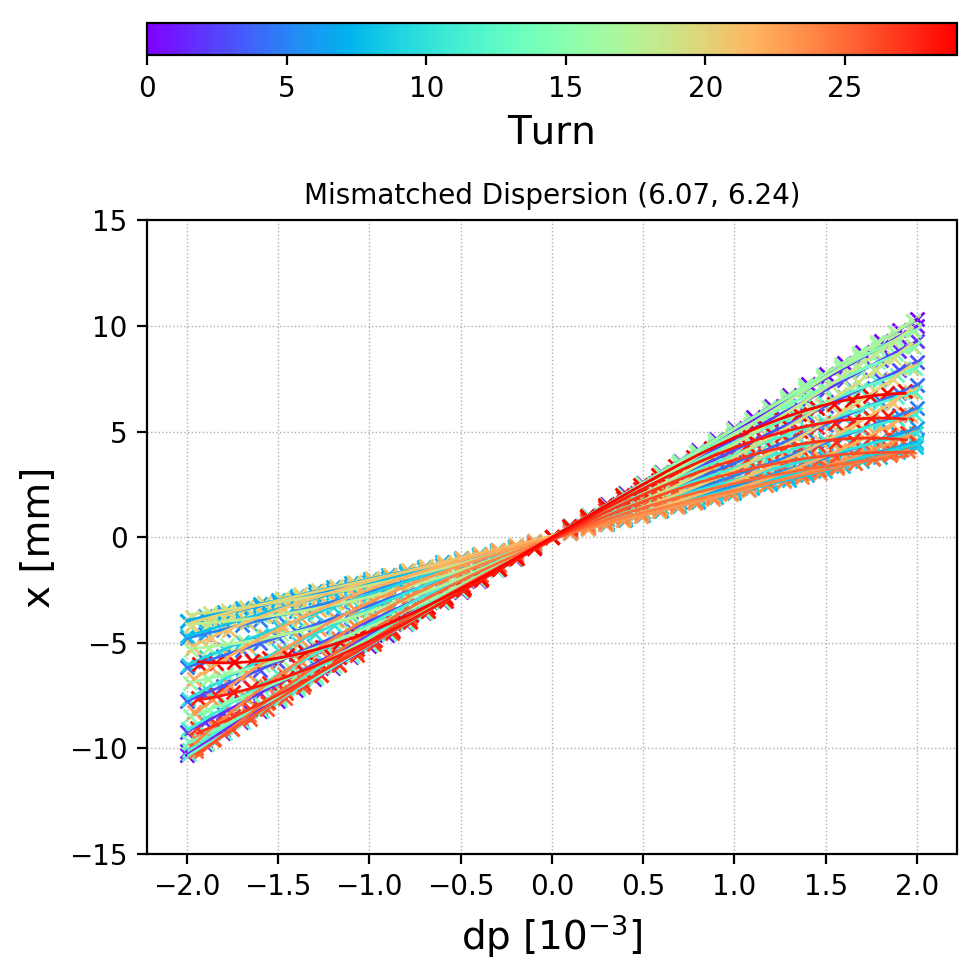

In [35]:
d_case = d1_H_07
case_label = '1_H_07'

# arrays to hold fitted values
D_1 = []
D_2 = []
D_3 = []
D_i = []

# Plot parameters
plt.rcParams['figure.figsize'] = [5.0, 5.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['lines.linewidth'] = 1

# Create figure
#fig1, ax1 = plt.subplots(1);
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20]) 
ax2 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

#fig1, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, width_ratios=widths, height_ratios=heights)

# Select parameters and labels etc
parameter1 = 'dE';
parameter2 = 'x';
multi1 = 1E3;
multi2 = 1E3;
ax1.set_xlabel(r'dp [$10^{-3}$]');
ax1.set_ylabel('x [mm]');
ax1.grid(which='both',linewidth=0.5, ls=':');
ax1.set_ylim(-15, 15);

transverse_plane = case_label.split('_')[1]
dispersion_mismatch = int(case_label.split('_')[0][-1])
tune = int(case_label.split('_')[2])
if transverse_plane is 'H':
    full_tune = str('(6.'+ case_label.split('_')[2] +', 6.24)')
else:
    full_tune = str('(6.21, 6.'+ case_label.split('_')[2] +')')
    
if dispersion_mismatch:
    d_mismatch_label = 'Mismatched Dispersion '
else:
    d_mismatch_label = 'Lattice Dispersion '

full_title = d_mismatch_label+full_tune

ax1.set_title(full_title)

# Iterate over turn
maxi = 30
turns = range(0,maxi)

colors = cm.rainbow(np.linspace(0, 1, len(turns)))
c_it = 0

cmap = mpl.cm.rainbow
norm = mpl.colors.Normalize(vmin=np.min(turns), vmax=np.max(turns))
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal')
cb1.set_label('Turn')

for n in turns:  
   
    x = np.array(multi1 * d[n]['particles'][parameter1][0][0][0]/E/beta**2) #Conversion from dE to dpp
    y = np.array(multi2 * d[n]['particles'][parameter2][0][0][0])
    ax1.scatter(x, y, marker='x', label=str(n), color=colors[c_it]);

    min_dp = np.min(x)
    max_dp = np.max(x)
    DELTAP_range = np.arange(min_dp, max_dp, 1E-3);

    popt, pcov = curve_fit(cubic, x, y);

    D_1.append(popt[1]);
    D_2.append(popt[0]);
    D_3.append(popt[3]);
    D_i.append(popt[2]);
    ax1.plot(DELTAP_range, cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3]), color=colors[c_it]);
    c_it = c_it + 1;
    
savename = dispersion_vector_save_folder +'/' + case_label + '_dispersion_vector.png'
plt.savefig(savename);

master_dict[case_label] = dict()
master_dict[case_label]['D_1'] = D_1
master_dict[case_label]['D_2'] = D_2
master_dict[case_label]['D_3'] = D_3
master_dict[case_label]['D_i'] = D_i

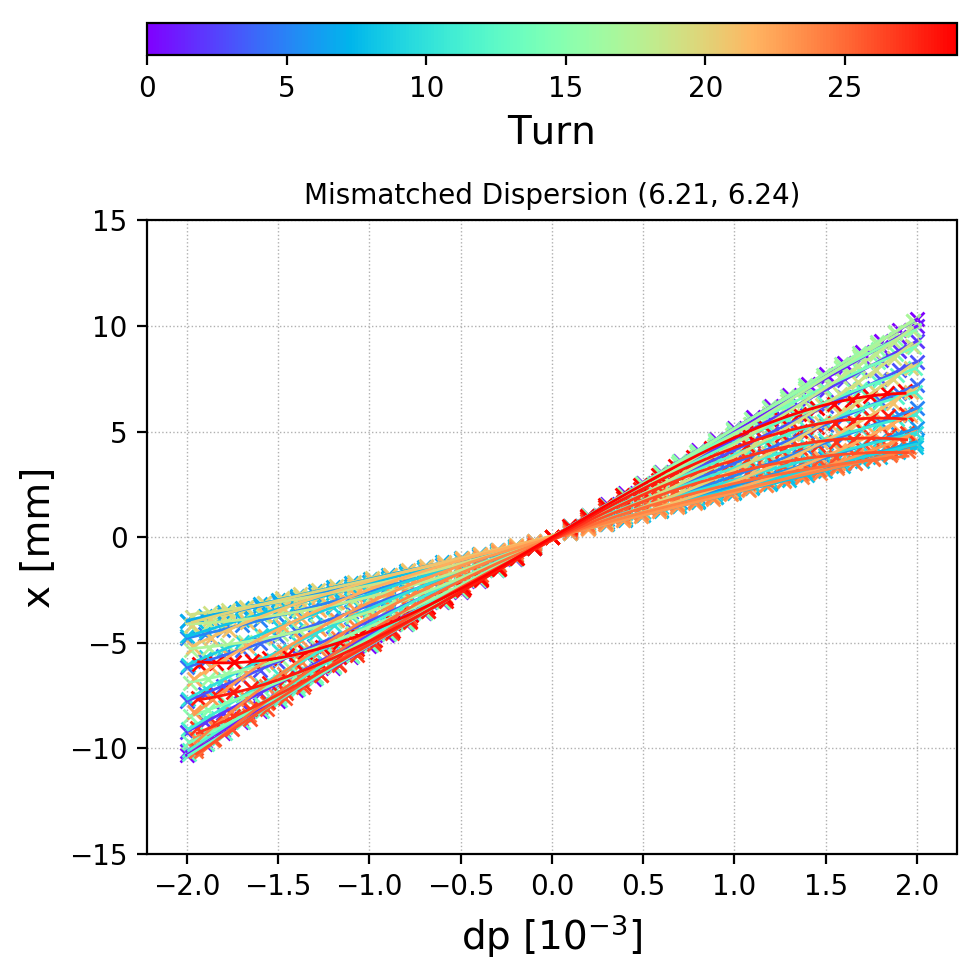

In [36]:
d_case = d1_H_21
case_label = '1_H_21'

# arrays to hold fitted values
D_1 = []
D_2 = []
D_3 = []
D_i = []

# Plot parameters
plt.rcParams['figure.figsize'] = [5.0, 5.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['lines.linewidth'] = 1

# Create figure
#fig1, ax1 = plt.subplots(1);
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20]) 
ax2 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

#fig1, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, width_ratios=widths, height_ratios=heights)

# Select parameters and labels etc
parameter1 = 'dE';
parameter2 = 'x';
multi1 = 1E3;
multi2 = 1E3;
ax1.set_xlabel(r'dp [$10^{-3}$]');
ax1.set_ylabel('x [mm]');
ax1.grid(which='both',linewidth=0.5, ls=':');
ax1.set_ylim(-15, 15);

transverse_plane = case_label.split('_')[1]
dispersion_mismatch = int(case_label.split('_')[0][-1])
tune = int(case_label.split('_')[2])
if transverse_plane is 'H':
    full_tune = str('(6.'+ case_label.split('_')[2] +', 6.24)')
else:
    full_tune = str('(6.21, 6.'+ case_label.split('_')[2] +')')
    
if dispersion_mismatch:
    d_mismatch_label = 'Mismatched Dispersion '
else:
    d_mismatch_label = 'Lattice Dispersion '

full_title = d_mismatch_label+full_tune

ax1.set_title(full_title)

# Iterate over turn
maxi = 30
turns = range(0,maxi)

colors = cm.rainbow(np.linspace(0, 1, len(turns)))
c_it = 0

cmap = mpl.cm.rainbow
norm = mpl.colors.Normalize(vmin=np.min(turns), vmax=np.max(turns))
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal')
cb1.set_label('Turn')

for n in turns:  
   
    x = np.array(multi1 * d[n]['particles'][parameter1][0][0][0]/E/beta**2) #Conversion from dE to dpp
    y = np.array(multi2 * d[n]['particles'][parameter2][0][0][0])
    ax1.scatter(x, y, marker='x', label=str(n), color=colors[c_it]);

    min_dp = np.min(x)
    max_dp = np.max(x)
    DELTAP_range = np.arange(min_dp, max_dp, 1E-3);

    popt, pcov = curve_fit(cubic, x, y);

    D_1.append(popt[1]);
    D_2.append(popt[0]);
    D_3.append(popt[3]);
    D_i.append(popt[2]);
    ax1.plot(DELTAP_range, cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3]), color=colors[c_it]);
    c_it = c_it + 1;
    
savename = dispersion_vector_save_folder +'/' + case_label + '_dispersion_vector.png'
plt.savefig(savename);

master_dict[case_label] = dict()
master_dict[case_label]['D_1'] = D_1
master_dict[case_label]['D_2'] = D_2
master_dict[case_label]['D_3'] = D_3
master_dict[case_label]['D_i'] = D_i

In [37]:
master_dict['1_H_07']['D_1'][0]

5.163067143737946

In [38]:
for key, value in H_Mismatch_Dict.iteritems():

    d = value
    case_label = key

    # arrays to hold fitted values
    D_1 = []
    D_2 = []
    D_3 = []
    D_i = []

    # Plot parameters
    plt.rcParams['figure.figsize'] = [5.0, 5.0]
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['font.size'] = 10
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['lines.linewidth'] = 1

    # Create figure
    #fig1, ax1 = plt.subplots(1);
    fig = plt.figure(tight_layout=True);
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20]);
    ax2 = plt.subplot(gs[0]);
    ax1 = plt.subplot(gs[1]);

    #fig1, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, width_ratios=widths, height_ratios=heights)

    # Select parameters and labels etc
    parameter1 = 'dE';
    parameter2 = 'x';
    multi1 = 1E3;
    multi2 = 1E3;
    ax1.set_xlabel(r'dp [$10^{-3}$]');
    ax1.set_ylabel('x [mm]');
    ax1.grid(which='both',linewidth=0.5, ls=':');
    ax1.set_ylim(-15, 15);

    transverse_plane = case_label.split('_')[1];
    dispersion_mismatch = int(case_label.split('_')[0][-1]);
    tune = int(case_label.split('_')[2]);
    if transverse_plane is 'H':
        full_tune = str('(6.'+ case_label.split('_')[2] +', 6.24)');
    else:
        full_tune = str('(6.21, 6.'+ case_label.split('_')[2] +')');

    if dispersion_mismatch:
        d_mismatch_label = 'Mismatched Dispersion ';
    else:
        d_mismatch_label = 'Lattice Dispersion ';

    full_title = d_mismatch_label+full_tune;

    ax1.set_title(full_title);

    # Iterate over turn
    maxi = 30;
    turns = range(0,maxi);

    colors = cm.rainbow(np.linspace(0, 1, len(turns)));
    c_it = 0;

    cmap = mpl.cm.rainbow;
    norm = mpl.colors.Normalize(vmin=np.min(turns), vmax=np.max(turns));
    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal');
    cb1.set_label('Turn');

    for n in turns:  

        x = np.array(multi1 * d[n]['particles'][parameter1][0][0][0]/E/beta**2); #Conversion from dE to dpp
        y = np.array(multi2 * d[n]['particles'][parameter2][0][0][0]);
        ax1.scatter(x, y, marker='x', label=str(n), color=colors[c_it]);

        min_dp = np.min(x);
        max_dp = np.max(x);
        DELTAP_range = np.arange(min_dp, max_dp, 1E-3);

        popt, pcov = curve_fit(cubic, x, y);

        D_1.append(popt[1]);
        D_2.append(popt[0]);
        D_3.append(popt[3]);
        D_i.append(popt[2]);
        ax1.plot(DELTAP_range, cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3]), color=colors[c_it]);
        c_it = c_it + 1;

    savename = dispersion_vector_save_folder +'/' + case_label + '_dispersion_vector.png';
    plt.savefig(savename);
    plt.clf();

    master_dict[case_label] = dict()
    master_dict[case_label]['D_1'] = D_1
    master_dict[case_label]['D_2'] = D_2
    master_dict[case_label]['D_3'] = D_3
    master_dict[case_label]['D_i'] = D_i

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [39]:
for key, value in H_No_Mismatch_Dict.iteritems():

    d = value
    case_label = key

    # arrays to hold fitted values
    D_1 = []
    D_2 = []
    D_3 = []
    D_i = []

    # Plot parameters
    plt.rcParams['figure.figsize'] = [5.0, 5.0]
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['font.size'] = 10
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['lines.linewidth'] = 1

    # Create figure
    #fig1, ax1 = plt.subplots(1);
    fig = plt.figure(tight_layout=True);
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20]);
    ax2 = plt.subplot(gs[0]);
    ax1 = plt.subplot(gs[1]);

    #fig1, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, width_ratios=widths, height_ratios=heights)

    # Select parameters and labels etc
    parameter1 = 'dE';
    parameter2 = 'x';
    multi1 = 1E3;
    multi2 = 1E3;
    ax1.set_xlabel(r'dp [$10^{-3}$]');
    ax1.set_ylabel('x [mm]');
    ax1.grid(which='both',linewidth=0.5, ls=':');
    ax1.set_ylim(-15, 15);

    transverse_plane = case_label.split('_')[1];
    dispersion_mismatch = int(case_label.split('_')[0][-1]);
    tune = int(case_label.split('_')[2]);
    if transverse_plane is 'H':
        full_tune = str('(6.'+ case_label.split('_')[2] +', 6.24)');
    else:
        full_tune = str('(6.21, 6.'+ case_label.split('_')[2] +')');

    if dispersion_mismatch:
        d_mismatch_label = 'Mismatched Dispersion ';
    else:
        d_mismatch_label = 'Lattice Dispersion ';

    full_title = d_mismatch_label+full_tune;

    ax1.set_title(full_title);

    # Iterate over turn
    maxi = 30;
    turns = range(0,maxi);

    colors = cm.rainbow(np.linspace(0, 1, len(turns)));
    c_it = 0;

    cmap = mpl.cm.rainbow;
    norm = mpl.colors.Normalize(vmin=np.min(turns), vmax=np.max(turns));
    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal');
    cb1.set_label('Turn');

    for n in turns:  

        x = np.array(multi1 * d[n]['particles'][parameter1][0][0][0]/E/beta**2); #Conversion from dE to dpp
        y = np.array(multi2 * d[n]['particles'][parameter2][0][0][0]);
        ax1.scatter(x, y, marker='x', label=str(n), color=colors[c_it]);

        min_dp = np.min(x);
        max_dp = np.max(x);
        DELTAP_range = np.arange(min_dp, max_dp, 1E-3);

        popt, pcov = curve_fit(cubic, x, y);

        D_1.append(popt[1]);
        D_2.append(popt[0]);
        D_3.append(popt[3]);
        D_i.append(popt[2]);
        ax1.plot(DELTAP_range, cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3]), color=colors[c_it]);
        c_it = c_it + 1;

    savename = dispersion_vector_save_folder +'/' + case_label + '_dispersion_vector.png';
    plt.savefig(savename);
    plt.clf();

    master_dict[case_label] = dict()
    master_dict[case_label]['D_1'] = D_1
    master_dict[case_label]['D_2'] = D_2
    master_dict[case_label]['D_3'] = D_3
    master_dict[case_label]['D_i'] = D_i

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [40]:
for key, value in V_No_Mismatch_Dict.iteritems():

    d = value
    case_label = key

    # arrays to hold fitted values
    D_1 = []
    D_2 = []
    D_3 = []
    D_i = []

    # Plot parameters
    plt.rcParams['figure.figsize'] = [5.0, 5.0]
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['font.size'] = 10
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['lines.linewidth'] = 1

    # Create figure
    #fig1, ax1 = plt.subplots(1);
    fig = plt.figure(tight_layout=True);
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20]);
    ax2 = plt.subplot(gs[0]);
    ax1 = plt.subplot(gs[1]);

    #fig1, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, width_ratios=widths, height_ratios=heights)

    # Select parameters and labels etc
    parameter1 = 'dE';
    parameter2 = 'x';
    multi1 = 1E3;
    multi2 = 1E3;
    ax1.set_xlabel(r'dp [$10^{-3}$]');
    ax1.set_ylabel('x [mm]');
    ax1.grid(which='both',linewidth=0.5, ls=':');
    ax1.set_ylim(-15, 15);

    transverse_plane = case_label.split('_')[1];
    dispersion_mismatch = int(case_label.split('_')[0][-1]);
    tune = int(case_label.split('_')[2]);
    if transverse_plane is 'H':
        full_tune = str('(6.'+ case_label.split('_')[2] +', 6.24)');
    else:
        full_tune = str('(6.21, 6.'+ case_label.split('_')[2] +')');

    if dispersion_mismatch:
        d_mismatch_label = 'Mismatched Dispersion ';
    else:
        d_mismatch_label = 'Lattice Dispersion ';

    full_title = d_mismatch_label+full_tune;

    ax1.set_title(full_title);

    # Iterate over turn
    maxi = 30;
    turns = range(0,maxi);

    colors = cm.rainbow(np.linspace(0, 1, len(turns)));
    c_it = 0;

    cmap = mpl.cm.rainbow;
    norm = mpl.colors.Normalize(vmin=np.min(turns), vmax=np.max(turns));
    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal');
    cb1.set_label('Turn');

    for n in turns:  

        x = np.array(multi1 * d[n]['particles'][parameter1][0][0][0]/E/beta**2); #Conversion from dE to dpp
        y = np.array(multi2 * d[n]['particles'][parameter2][0][0][0]);
        ax1.scatter(x, y, marker='x', label=str(n), color=colors[c_it]);

        min_dp = np.min(x);
        max_dp = np.max(x);
        DELTAP_range = np.arange(min_dp, max_dp, 1E-3);

        popt, pcov = curve_fit(cubic, x, y);

        D_1.append(popt[1]);
        D_2.append(popt[0]);
        D_3.append(popt[3]);
        D_i.append(popt[2]);
        ax1.plot(DELTAP_range, cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3]), color=colors[c_it]);
        c_it = c_it + 1;

    savename = dispersion_vector_save_folder +'/' + case_label + '_dispersion_vector.png';
    plt.savefig(savename);
    plt.clf();

    master_dict[case_label] = dict()
    master_dict[case_label]['D_1'] = D_1
    master_dict[case_label]['D_2'] = D_2
    master_dict[case_label]['D_3'] = D_3
    master_dict[case_label]['D_i'] = D_i

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [41]:
for key, value in V_Mismatch_Dict.iteritems():

    d = value
    case_label = key

    # arrays to hold fitted values
    D_1 = []
    D_2 = []
    D_3 = []
    D_i = []

    # Plot parameters
    plt.rcParams['figure.figsize'] = [5.0, 5.0]
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['font.size'] = 10
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['lines.linewidth'] = 1

    # Create figure
    #fig1, ax1 = plt.subplots(1);
    fig = plt.figure(tight_layout=True);
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20]);
    ax2 = plt.subplot(gs[0]);
    ax1 = plt.subplot(gs[1]);

    #fig1, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, width_ratios=widths, height_ratios=heights)

    # Select parameters and labels etc
    parameter1 = 'dE';
    parameter2 = 'x';
    multi1 = 1E3;
    multi2 = 1E3;
    ax1.set_xlabel(r'dp [$10^{-3}$]');
    ax1.set_ylabel('x [mm]');
    ax1.grid(which='both',linewidth=0.5, ls=':');
    ax1.set_ylim(-15, 15);

    transverse_plane = case_label.split('_')[1];
    dispersion_mismatch = int(case_label.split('_')[0][-1]);
    tune = int(case_label.split('_')[2]);
    if transverse_plane is 'H':
        full_tune = str('(6.'+ case_label.split('_')[2] +', 6.24)');
    else:
        full_tune = str('(6.21, 6.'+ case_label.split('_')[2] +')');

    if dispersion_mismatch:
        d_mismatch_label = 'Mismatched Dispersion ';
    else:
        d_mismatch_label = 'Lattice Dispersion ';

    full_title = d_mismatch_label+full_tune;

    ax1.set_title(full_title);

    # Iterate over turn
    maxi = 30;
    turns = range(0,maxi);

    colors = cm.rainbow(np.linspace(0, 1, len(turns)));
    c_it = 0;

    cmap = mpl.cm.rainbow;
    norm = mpl.colors.Normalize(vmin=np.min(turns), vmax=np.max(turns));
    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal');
    cb1.set_label('Turn');

    for n in turns:  

        x = np.array(multi1 * d[n]['particles'][parameter1][0][0][0]/E/beta**2); #Conversion from dE to dpp
        y = np.array(multi2 * d[n]['particles'][parameter2][0][0][0]);
        ax1.scatter(x, y, marker='x', label=str(n), color=colors[c_it]);

        min_dp = np.min(x);
        max_dp = np.max(x);
        DELTAP_range = np.arange(min_dp, max_dp, 1E-3);

        popt, pcov = curve_fit(cubic, x, y);

        D_1.append(popt[1]);
        D_2.append(popt[0]);
        D_3.append(popt[3]);
        D_i.append(popt[2]);
        ax1.plot(DELTAP_range, cubic(DELTAP_range,popt[0],popt[1],popt[2],popt[3]), color=colors[c_it]);
        c_it = c_it + 1;

    savename = dispersion_vector_save_folder +'/' + case_label + '_dispersion_vector.png';
    plt.savefig(savename);
    plt.clf();

    master_dict[case_label] = dict()
    master_dict[case_label]['D_1'] = D_1
    master_dict[case_label]['D_2'] = D_2
    master_dict[case_label]['D_3'] = D_3
    master_dict[case_label]['D_i'] = D_i

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

# Test plotting of linear dispersion

In [42]:
dispersion_save_folder = 'Linear_Dispersion'
make_directory(dispersion_save_folder)

Creation of the directory Linear_Dispersion failed


In [43]:
linear_dispersion_fit_dict = dict()

for key, value in master_dict.iteritems():

    d = value
    case_label = key

    # Plot parameters
    plt.rcParams['figure.figsize'] = [5.0, 5.0]
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['font.size'] = 10
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['lines.linewidth'] = 1

    # Create figure
    #fig1, ax1 = plt.subplots(1);
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(1, 1) 
    ax1 = plt.subplot(gs[0])

    #fig1, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, width_ratios=widths, height_ratios=heights)

    # Select parameters and labels etc
    parameter1 = 'D_1';
    
    multi1 = 1;
    
    ax1.set_xlabel('Turn [-]');
    ax1.set_ylabel(r'$D_x$ [m]');    
    ax1.grid(which='both',linewidth=0.5, ls=':');
    ax1.set_ylim(0.5, 5.5);

    transverse_plane = case_label.split('_')[1]
    dispersion_mismatch = int(case_label.split('_')[0][-1])
    tune = int(case_label.split('_')[2])
    if transverse_plane is 'H':
        full_tune = str('(6.'+ case_label.split('_')[2] +', 6.24)')
    else:
        full_tune = str('(6.21, 6.'+ case_label.split('_')[2] +')')
        

    if dispersion_mismatch:
        d_mismatch_label = 'Mismatched Dispersion '
    else:
        d_mismatch_label = 'Lattice Dispersion '

    full_title = d_mismatch_label+full_tune

    ax1.set_title(full_title)
    
    y = np.array(multi1 * d[parameter1])
    x = range(0,30)
    turns_fine = np.arange(0, 31, 0.1)
    
    if dispersion_mismatch:
        D_0_min = -np.inf# 2.0
        D_0_max = np.inf# 4.0
        M_D_min = 0.98* (np.max(y) - np.min(y))/2
        M_D_max = 1.02* (np.max(y) - np.min(y))/2
        theta_min = -np.inf;
        theta_max = np.inf;
        if transverse_plane is 'H':
            qx_min = (int(case_label.split('_')[2])/100.)*(6+(int(case_label.split('_')[2])/100.))* 0.9
            qx_max = (int(case_label.split('_')[2])/100.)*(6+(int(case_label.split('_')[2])/100.))* 1.1
        else:
            qx_min = 0.21*6.21*0.95 # 1.3#0.
            qx_max = 0.21*6.21*1.05 # 1.4#2*np.pi


        popt, pcov = curve_fit(Md_fit, x, y, method = 'trf', bounds =((D_0_min,M_D_min,qx_min,theta_min),(D_0_max,M_D_max,qx_max,theta_max)));
        
        linear_dispersion_fit_dict[case_label] = dict();
        linear_dispersion_fit_dict[case_label]['D_0'] = popt[0];
        linear_dispersion_fit_dict[case_label]['Amplitude'] = popt[1];
        linear_dispersion_fit_dict[case_label]['Frequency'] = popt[2];
        linear_dispersion_fit_dict[case_label]['Theta'] = popt[3];
        
        plt.plot(turns_fine, Md_fit(turns_fine, popt[0], popt[1], popt[2], popt[3]),'r', label='Harmonic Fit');        
        
        print case_label, round_sig(popt[0]), round_sig(popt[1]), round_sig(popt[2]), round_sig(popt[3]);
        lab_ = 'Mean Dispersion = ' + str(round_sig(popt[0])) + ' m'
        plt.plot([x[0], x[-1]], [popt[0],popt[0]],'--k', label=lab_); 
        
        
    ax1.plot(x, y, marker='x', label='Dispersion Vector: Fitted Linear Dispersion');
    ax1.legend(fontsize=8);
    
    savename = dispersion_save_folder +'/' + case_label + '_dispersion.png'
    plt.savefig(savename);
    plt.clf();

1_V_10 2.416 1.21 1.317 -0.004735
1_V_11 2.412 1.21 1.317 -0.004036
1_V_12 2.407 1.211 1.317 -0.003336
1_V_13 2.403 1.211 1.317 -0.002634
1_V_19 2.376 1.214 1.317 0.001579
1_V_15 2.394 1.212 1.317 -0.00123


/usr/lib64/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1_H_09 3.491 1.576 0.5632 -0.03323
1_H_08 3.536 1.57 0.5004 -0.03745
1_H_21 3.123 1.627 1.317 -0.03242
1_H_20 3.148 1.557 1.254 -0.02967
1_V_16 2.389 1.213 1.317 -0.0005272
1_H_17 3.211 1.622 1.065 -0.02465
1_V_14 2.398 1.212 1.317 -0.001932
1_V_21 2.367 1.215 1.317 0.00298
1_V_20 2.372 1.215 1.317 0.00228
1_V_23 2.358 1.216 1.317 0.004378
1_V_22 2.363 1.216 1.317 0.003679
1_H_14 3.288 1.611 0.8771 -0.02785
1_H_15 3.26 1.619 0.9397 -0.02591
1_H_12 3.358 1.602 0.7511 -0.02436
1_H_13 3.326 1.611 0.8144 -0.02816
1_H_10 3.44 1.591 0.6255 -0.02664
1_H_11 3.389 1.597 0.6891 -0.03397
1_V_17 2.385 1.213 1.317 0.0001752
1_H_18 3.184 1.626 1.129 -0.0311
1_H_19 3.169 1.624 1.191 -0.02739
1_H_16 3.24 1.619 1.003 -0.02971
1_V_24 2.354 1.217 1.317 0.005075
1_H_07 3.6 1.55 0.4374 -0.04038
1_V_18 2.38 1.214 1.317 0.0008773


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [44]:
for key, value in sorted(linear_dispersion_fit_dict.iteritems()):
    transverse_plane = key.split('_')[1]
    dispersion_mismatch = int(key.split('_')[0][-1])
    tune = int(key.split('_')[2])/100.
    
    if transverse_plane is 'H':
        print transverse_plane, dispersion_mismatch, tune, (tune*(6.+tune)), round_sig(linear_dispersion_fit_dict[key]['Frequency']), round_sig(linear_dispersion_fit_dict[key]['Frequency'])/(6.+tune)
    else:
        print transverse_plane, dispersion_mismatch, tune, (0.21*(6.21)), round_sig(linear_dispersion_fit_dict[key]['Frequency']), round_sig(linear_dispersion_fit_dict[key]['Frequency'])/6.21
        

H 1 0.07 0.4249 0.4374 0.0720593080725
H 1 0.08 0.4864 0.5004 0.0823026315789
H 1 0.09 0.5481 0.5632 0.0924794745484
H 1 0.1 0.61 0.6255 0.102540983607
H 1 0.11 0.6721 0.6891 0.112782324059
H 1 0.12 0.7344 0.7511 0.12272875817
H 1 0.13 0.7969 0.8144 0.132854812398
H 1 0.14 0.8596 0.8771 0.142850162866
H 1 0.15 0.9225 0.9397 0.152796747967
H 1 0.16 0.9856 1.003 0.162824675325
H 1 0.17 1.0489 1.065 0.172609400324
H 1 0.18 1.1124 1.129 0.182686084142
H 1 0.19 1.1761 1.191 0.192407108239
H 1 0.2 1.24 1.254 0.202258064516
H 1 0.21 1.3041 1.317 0.212077294686
V 1 0.1 1.3041 1.317 0.212077294686
V 1 0.11 1.3041 1.317 0.212077294686
V 1 0.12 1.3041 1.317 0.212077294686
V 1 0.13 1.3041 1.317 0.212077294686
V 1 0.14 1.3041 1.317 0.212077294686
V 1 0.15 1.3041 1.317 0.212077294686
V 1 0.16 1.3041 1.317 0.212077294686
V 1 0.17 1.3041 1.317 0.212077294686
V 1 0.18 1.3041 1.317 0.212077294686
V 1 0.19 1.3041 1.317 0.212077294686
V 1 0.2 1.3041 1.317 0.212077294686
V 1 0.21 1.3041 1.317 0.21207729468

## Interesting point:
- The frequency of the dispersion mismatch oscillation is equal to $q_x \cdot Q_x$
- where $q_x$ is the fractional horizontal tune (e.g. 0.07), and $Q_x$ is the complete horizontal tune (e.g. 6.07)


# Plot normalised dispersion

In [45]:
normalised_dispersion_save_folder = 'Normalised_Dispersion'
make_directory(normalised_dispersion_save_folder)

Creation of the directory Normalised_Dispersion failed


In [46]:
normalised_linear_dispersion_fit_dict = dict()

for key, value in master_dict.iteritems():

    d = value
    case_label = key

    # Plot parameters
    plt.rcParams['figure.figsize'] = [5.0, 5.0]
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['savefig.dpi'] = 200
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['font.size'] = 10
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['lines.linewidth'] = 1

    # Create figure
    #fig1, ax1 = plt.subplots(1);
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(1, 1) 
    ax1 = plt.subplot(gs[0])

    #fig1, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, constrained_layout=True, width_ratios=widths, height_ratios=heights)

    # Select parameters and labels etc
    parameter1 = 'D_1';
    
    multi1 = 1;
    
    ax1.set_xlabel('Turn [-]');
    ax1.set_ylabel(r'$\frac{D_x}{\sqrt{\beta_x}}$ [m$^{\frac{1}{2}}$]');    
    ax1.grid(which='both',linewidth=0.5, ls=':');
    ax1.set_ylim(0.0, 1.25);

    transverse_plane = case_label.split('_')[1]
    dispersion_mismatch = int(case_label.split('_')[0][-1])
    tune = int(case_label.split('_')[2])
    twiss_dict_label = transverse_plane + '_' + case_label.split('_')[2]
    
    if transverse_plane is 'H':
        full_tune = str('(6.'+ case_label.split('_')[2] +', 6.24)')
    else:
        full_tune = str('(6.21, 6.'+ case_label.split('_')[2] +')')
        

    if dispersion_mismatch:
        d_mismatch_label = 'Mismatched Dispersion '
    else:
        d_mismatch_label = 'Lattice Dispersion '

    full_title = d_mismatch_label+full_tune

    ax1.set_title(full_title)
    
    y = np.array(multi1 * d[parameter1])/np.sqrt(twiss_dict[twiss_dict_label]['BETX'])
    x = range(0,30)
    turns_fine = np.arange(0, 31, 0.1)
    
    if dispersion_mismatch:
        D_0_min = -np.inf# 2.0
        D_0_max = np.inf# 4.0
        M_D_min = 0.98* (np.max(y) - np.min(y))/2
        M_D_max = 1.02* (np.max(y) - np.min(y))/2
        theta_min = -np.inf;
        theta_max = np.inf;
        if transverse_plane is 'H':
            qx_min = (int(case_label.split('_')[2])/100.)*(6+(int(case_label.split('_')[2])/100.))* 0.9
            qx_max = (int(case_label.split('_')[2])/100.)*(6+(int(case_label.split('_')[2])/100.))* 1.1
        else:
            qx_min = 0.21*6.21*0.95 # 1.3#0.
            qx_max = 0.21*6.21*1.05 # 1.4#2*np.pi


        popt, pcov = curve_fit(Md_fit, x, y, method = 'trf', bounds =((D_0_min,M_D_min,qx_min,theta_min),(D_0_max,M_D_max,qx_max,theta_max)));
        
        normalised_linear_dispersion_fit_dict[case_label] = dict();
        normalised_linear_dispersion_fit_dict[case_label]['D_0'] = popt[0];
        normalised_linear_dispersion_fit_dict[case_label]['Amplitude'] = popt[1];
        normalised_linear_dispersion_fit_dict[case_label]['Frequency'] = popt[2];
        normalised_linear_dispersion_fit_dict[case_label]['Theta'] = popt[3];
        lab_2 = 'Harmonic Fit, Amplitude = ' + str(round_sig(popt[1]))        
        plt.plot(turns_fine, Md_fit(turns_fine, popt[0], popt[1], popt[2], popt[3]),'r', label=lab_2);        
        
        print case_label, round_sig(popt[0]), round_sig(popt[1]), round_sig(popt[2]), round_sig(popt[3]);
        lab_ = 'Mean Normalised Dispersion = ' + str(round_sig(popt[0]))
        plt.plot([x[0], x[-1]], [popt[0],popt[0]],'--k', label=lab_); 
        
    ax1.plot(x, y, marker='x', label='Dispersion Vector: Fitted Normalised Linear Dispersion');
    ax1.legend(fontsize=8, loc=3);
    
    savename = normalised_dispersion_save_folder +'/' + case_label + '_normalised_dispersion.png'
    plt.savefig(savename);
    plt.clf();

1_V_10 0.6885 0.3447 1.317 -0.004735
1_V_11 0.6869 0.3447 1.317 -0.004036
1_V_12 0.6852 0.3447 1.317 -0.003336
1_V_13 0.6836 0.3447 1.317 -0.002634
1_V_19 0.674 0.3445 1.317 0.001579
1_V_15 0.6804 0.3446 1.317 -0.00123
1_H_09 0.767 0.3462 0.5632 -0.03323
1_H_08 0.7842 0.3482 0.5004 -0.03745
1_H_21 0.6611 0.3444 1.317 -0.03242
1_H_20 0.667 0.3299 1.254 -0.02967
1_V_16 0.6787 0.3446 1.317 -0.0005272
1_H_17 0.6833 0.3452 1.065 -0.02465
1_V_14 0.682 0.3446 1.317 -0.001932
1_V_21 0.6708 0.3444 1.317 0.00298
1_V_20 0.6724 0.3444 1.317 0.00228
1_V_23 0.6677 0.3444 1.317 0.004378
1_V_22 0.6692 0.3444 1.317 0.003679
1_H_14 0.7043 0.3451 0.8771 -0.02785
1_H_15 0.6966 0.3459 0.9397 -0.02591
1_H_12 0.7247 0.3458 0.7511 -0.02436
1_H_13 0.715 0.3462 0.8144 -0.02816
1_H_10 0.7501 0.3469 0.6255 -0.02664
1_H_11 0.7348 0.3462 0.6891 -0.03397
1_V_17 0.6771 0.3445 1.317 0.0001752
1_H_18 0.6764 0.3454 1.129 -0.0311
1_H_19 0.6722 0.3445 1.191 -0.02739
1_H_16 0.6907 0.345 1.003 -0.02971
1_V_24 0.6661 0.3443 

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>